In [1]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

2025-10-02 00:41:37.926184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def build_mlp(column_count, num_classes):
    inputs = keras.Input(shape=(column_count,))
    x = keras.layers.Dense(256, activation='relu')(inputs)
    x = keras.layers.Dropout(0.6)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, output)

In [3]:
from sklearn.discriminant_analysis import StandardScaler


df = pd.read_csv('cumulative_2025.10.01_20.20.34.csv', comment='#')
cols_to_drop = [
    'rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat', 'koi_vet_date',
    'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 
    'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_eccen', 'koi_eccen_err1', 
    'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress', 
    'koi_ingress_err1', 'koi_ingress_err2',  'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 
    'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_limbdark_mod', 'koi_ldm_coeff4', 
    'koi_ldm_coeff3', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 
    'koi_bin_oedp_sig', 'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 
    'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2'
]

df = df.drop(columns=cols_to_drop)
df_clean = df.dropna()

Y = df_clean['koi_disposition']
X = df_clean.drop(columns=['koi_disposition'])

Y_encoded_df = pd.get_dummies(Y, drop_first=False)
labels = Y_encoded_df.columns

Y_encoded = Y_encoded_df.values
X_encoded = pd.get_dummies(X, drop_first=False).astype(np.float32).values

scaler = StandardScaler()
X_encoded = scaler.fit_transform(X_encoded).astype(np.float32)



In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_encoded, Y_encoded, test_size=0.2, random_state=42, shuffle=True
)

In [5]:
model = build_mlp(X_encoded.shape[1], Y_encoded.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy'
)
model.summary()

I0000 00:00:1759383701.654174  220171 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6631 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,395 (169.51 KB)

 Trainable params: 43,395 (169.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [7]:
model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=1000,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/1000


2025-10-02 00:41:43.970154: I external/local_xla/xla/service/service.cc:163] XLA service 0x79634c00a840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-02 00:41:43.970166: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-10-02 00:41:44.004540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-02 00:41:44.251351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


53/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3438

I0000 00:00:1759383706.542012  220312 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 1.2270 - val_loss: 0.9417
Epoch 2/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0572 - val_loss: 0.8554
Epoch 3/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9498 - val_loss: 0.7913
Epoch 4/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9029 - val_loss: 0.7386
Epoch 5/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8311 - val_loss: 0.6945
Epoch 6/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7991 - val_loss: 0.6610
Epoch 7/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7653 - val_loss: 0.6345
Epoch 8/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7419 - val_loss: 0.6078
Epoch 9/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7170 - val_loss: 0.5896
Epoch 10/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6920 - val_loss: 0.5713
Epoch 11/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6752 - val_loss: 0.5557
Epoch 12/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6

In [8]:
model.save('xd.keras')

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   
                precision    recall  f1-score   support

     CANDIDATE       0.71      0.65      0.68       265
     CONFIRMED       0.91      0.91      0.91       516
FALSE POSITIVE       0.90      0.93      0.92       595

      accuracy                           0.87      1376
     macro avg       0.84      0.83      0.83      1376
  weighted avg       0.86      0.87      0.87      1376



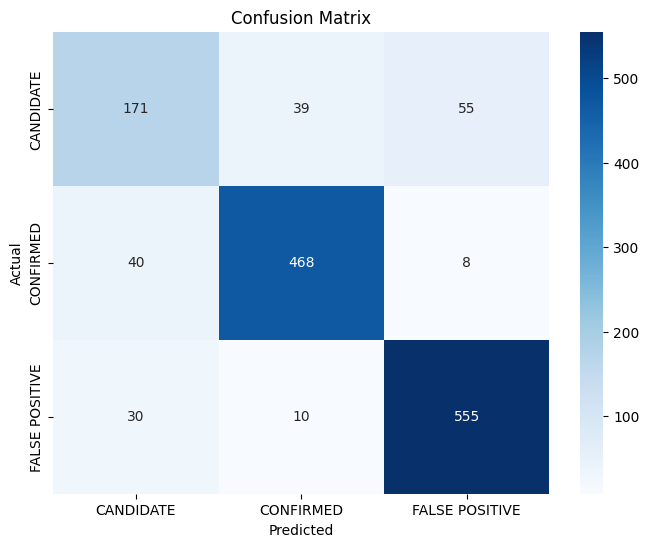

In [9]:
Y_pred_probs = model.predict(X_test)
Y_pred_indices = np.argmax(Y_pred_probs, axis=1)
Y_pred_strings = labels[Y_pred_indices]
Y_true_indices = np.argmax(Y_test, axis=1)
Y_true_strings = labels[Y_true_indices]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(Y_true_strings, Y_pred_strings, target_names=labels))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()